# 🧠 Z-Go Universal Orchestrator - Explained

**A beginner-friendly guide to text-to-image generation with diffusion models**

This notebook mirrors `app.py` but includes detailed explanations of every concept. By the end, you'll understand:

1. **What diffusion models are** and how they generate images
2. **GGUF quantization** - making large models run on consumer hardware
3. **Hardware acceleration** - CUDA, MPS, and CPU backends
4. **Memory optimization** - techniques to avoid out-of-memory errors
5. **The complete generation pipeline** from prompt to image

---

## Part 1: Understanding Diffusion Models 🎨

### What is a Diffusion Model?

Diffusion models generate images by **reversing a noise-adding process**:

```
Training (Forward Process):
Clean Image → Add Noise → Add Noise → ... → Pure Noise

Generation (Reverse Process):
Pure Noise → Remove Noise → Remove Noise → ... → Clean Image
```

**The key insight**: If we train a neural network to predict and remove small amounts of noise, we can start from random noise and iteratively "denoise" it into a coherent image!

### Why "Turbo"?

Normal diffusion models need 20-50 denoising steps. **Turbo** models are *distilled* to work in just **4-8 steps**:

| Model Type | Steps Needed | Time |
|------------|--------------|------|
| Standard | 20-50 | 2-5 min |
| Turbo | 4-8 | 30-60 sec |

This is achieved through **consistency distillation** - training the model to "skip" intermediate steps.

## Part 2: Setup & Imports 📦

Let's import everything we need with explanations:

In [9]:
pip install -r requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [1]:
# =============================================================================
# IMPORTS - Each library serves a specific purpose
# =============================================================================

import os           # Operating system interface - for environment variables
import sys          # System-specific parameters - for Python path manipulation
import platform     # Hardware/OS detection - to identify Apple Silicon vs Intel
import gc           # Garbage Collector - to manually free memory when needed
from pathlib import Path  # Modern file path handling - cleaner than os.path
from typing import Optional  # Type hints - makes code more readable
from PIL import Image  # Python Imaging Library - for image manipulation

# =============================================================================
# MEMORY OPTIMIZATION FOR APPLE SILICON (MPS)
# =============================================================================
# By default, PyTorch's MPS backend limits memory usage to prevent system crashes.
# Setting this to "0.0" removes that limit, allowing the model to use all available
# GPU memory. This is necessary for larger image sizes (1024x1024).
#
# WARNING: If your Mac runs out of memory, the app may crash. Use smaller sizes
# if you encounter issues.

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

print("✅ Environment configured!")

✅ Environment configured!


## Part 3: Configuration 🔧

### Understanding GGUF Quantization

**Quantization** reduces model size by using fewer bits to store numbers:

| Precision | Bits per Number | Model Size | Quality |
|-----------|-----------------|------------|----------|
| FP32 (Full) | 32 bits | ~24 GB | 100% |
| FP16 (Half) | 16 bits | ~12 GB | ~99% |
| **Q4_K_M** | 4 bits | ~5 GB | ~95% |

**GGUF** (GPT-Generated Unified Format) is a file format designed for quantized models. The `Q4_K_M` variant uses 4-bit quantization with "K-quant" algorithm for optimal quality/size tradeoff.

In [2]:
# =============================================================================
# CONFIGURATION - Where to find and store our model
# =============================================================================

# Get the directory where this notebook lives
# In a real script, we'd use: Path(__file__).parent.absolute()
# In a notebook, we use the current working directory
SCRIPT_DIR = Path.cwd()
WEIGHTS_DIR = SCRIPT_DIR / "weights"  # Where downloaded models are stored

# =============================================================================
# MODEL IDENTIFIERS
# =============================================================================
# 
# We use TWO sources:
# 1. GGUF quantized transformer (5GB) - the main "brain" of the model
# 2. Base model pipeline (text encoder, VAE) - supporting components
#
# This hybrid approach gives us:
# - Small download size (5GB instead of 24GB)
# - Full functionality (all components work together)

MODEL_REPO = "jayn7/Z-Image-Turbo-GGUF"      # Hugging Face repo with GGUF file
MODEL_FILE = "z_image_turbo-Q4_K_M.gguf"    # The quantized transformer weights
BASE_MODEL = "Tongyi-MAI/Z-Image-Turbo"     # Original model for other components

print(f"📁 Weights directory: {WEIGHTS_DIR}")
print(f"📦 Model file: {MODEL_FILE}")
print(f"🔗 Base model: {BASE_MODEL}")

📁 Weights directory: /Users/vikramlingam/Desktop/Image_Model/weights
📦 Model file: z_image_turbo-Q4_K_M.gguf
🔗 Base model: Tongyi-MAI/Z-Image-Turbo


## Part 4: Hardware Detection 💻

### Understanding Compute Backends

Deep learning can run on different hardware:

| Backend | Hardware | Speed | Memory |
|---------|----------|-------|--------|
| **CUDA** | NVIDIA GPU | ⚡ Fastest | 8-24 GB VRAM |
| **MPS** | Apple Silicon | ⚡ Fast | Shared with system |
| **CPU** | Any processor | 🐢 Slowest | Uses RAM |

**MPS** (Metal Performance Shaders) is Apple's GPU acceleration framework, available on M1/M2/M3 chips.

In [3]:
# =============================================================================
# HARDWARE DETECTION
# =============================================================================

def get_hardware_info() -> str:
    """
    Detect what hardware we're running on.
    
    Returns a human-readable string describing the system.
    
    Technical details:
    - platform.system() returns: 'Darwin' (macOS), 'Windows', 'Linux'
    - platform.machine() returns: 'arm64' (Apple Silicon), 'x86_64' (Intel)
    """
    system = platform.system()
    machine = platform.machine()
    
    # Check for Apple Silicon specifically
    if system == "Darwin" and machine == "arm64":
        return "Apple Silicon (M-series)"
    
    return f"{system} ({machine})"

# Test it!
print(f"🖥️ Detected hardware: {get_hardware_info()}")

🖥️ Detected hardware: Apple Silicon (M-series)


## Part 5: The Engine Loader 🚀

### Lazy Loading Pattern

**Lazy loading** means we don't load the model until we actually need it:

```python
# Eager loading (BAD for UX):
pipeline = load_model()  # User waits 2 minutes before seeing anything

# Lazy loading (GOOD for UX):
def generate():
    if pipeline is None:
        pipeline = load_model()  # Only loads when user clicks "Generate"
    return pipeline(...)
```

This provides **instant UI feedback** while deferring heavy computation.

In [4]:
# =============================================================================
# GLOBAL STATE - Stores our loaded model
# =============================================================================
#
# We use global variables here as a simple cache mechanism.
# Once loaded, the model stays in memory for fast subsequent generations.

_engine = None       # Will hold (pipeline, device) tuple
_engine_info = None  # Human-readable device name

print("🔧 Global state initialized (model not yet loaded)")

🔧 Global state initialized (model not yet loaded)


In [5]:
# =============================================================================
# THE ENGINE LOADER - Where the magic happens!
# =============================================================================

def get_engine():
    """
    Lazy load the Z-Image-Turbo pipeline.
    
    This function:
    1. Checks if model is already loaded (returns cached version)
    2. Downloads GGUF weights if not present (~5GB first time)
    3. Detects best available device (CUDA > MPS > CPU)
    4. Loads the quantized transformer
    5. Creates the full pipeline with memory optimizations
    
    Returns:
        tuple: ((pipeline, device), device_name)
    """
    global _engine, _engine_info
    
    # =========================================================================
    # CACHE CHECK - Return existing model if already loaded
    # =========================================================================
    if _engine is not None:
        print("📦 Using cached model")
        return _engine, _engine_info
    
    # =========================================================================
    # IMPORT HEAVY LIBRARIES - Only when needed
    # =========================================================================
    # These imports are inside the function to speed up initial script loading.
    # torch alone takes ~2 seconds to import!
    
    import torch
    from huggingface_hub import hf_hub_download
    from diffusers import ZImagePipeline, ZImageTransformer2DModel, GGUFQuantizationConfig
    
    print("\n" + "=" * 50)
    print("📦 Loading Model (First Time)")
    print("=" * 50)
    
    # =========================================================================
    # DOWNLOAD WEIGHTS - ~5GB, only happens once
    # =========================================================================
    
    WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)  # Create weights folder
    weight_path = WEIGHTS_DIR / MODEL_FILE
    
    if not weight_path.exists():
        print(f"   ⬇️ Downloading {MODEL_FILE} (~5GB)...")
        print("   This only happens once, be patient!")
        hf_hub_download(
            repo_id=MODEL_REPO,  # Which Hugging Face repository
            filename=MODEL_FILE,  # Which file to download
            local_dir=WEIGHTS_DIR,  # Where to save it
        )
    else:
        print(f"   ✅ Model found: {MODEL_FILE}")
    
    # =========================================================================
    # DEVICE SELECTION - Pick the fastest available hardware
    # =========================================================================
    #
    # Priority order:
    # 1. CUDA (NVIDIA GPU) - Best for NVIDIA users
    # 2. MPS (Metal) - Best for Apple Silicon
    # 3. CPU - Fallback for everyone else
    
    if torch.cuda.is_available():
        device = "cuda"
        _engine_info = "CUDA GPU"
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = "mps"
        _engine_info = "Apple MPS"
    else:
        device = "cpu"
        _engine_info = "CPU"
    
    print(f"   🖥️ Using device: {_engine_info}")
    
    # =========================================================================
    # LOAD TRANSFORMER - The "brain" that does the denoising
    # =========================================================================
    #
    # The transformer is the main neural network in Z-Image.
    # It takes noisy latents + text embeddings → predicts noise to remove.
    #
    # We load from GGUF with specific settings:
    # - quantization_config: Tells diffusers how to interpret the 4-bit weights
    # - torch_dtype=bfloat16: Uses "brain floating point" - good balance of
    #   precision and speed, especially on Apple Silicon
    
    print("   🧠 Loading transformer (this takes a minute)...")
    
    transformer = ZImageTransformer2DModel.from_single_file(
        str(weight_path),
        quantization_config=GGUFQuantizationConfig(compute_dtype=torch.bfloat16),
        torch_dtype=torch.bfloat16,
    )
    
    # =========================================================================
    # LOAD FULL PIPELINE - Adds text encoder, VAE, scheduler
    # =========================================================================
    #
    # A complete text-to-image pipeline has multiple components:
    #
    # 1. TEXT ENCODER: "A cat on the moon" → [0.23, -0.89, 0.45, ...]
    #    Converts your prompt into numerical embeddings
    #
    # 2. TRANSFORMER: Our GGUF model - does the actual denoising
    #
    # 3. VAE (Variational AutoEncoder): Latent → Pixels
    #    Converts small latent images (64x64) to full resolution (1024x1024)
    #
    # 4. SCHEDULER: Controls the denoising process
    #    Determines how much noise to remove at each step
    
    print("   🔧 Assembling full pipeline...")
    
    pipeline = ZImagePipeline.from_pretrained(
        BASE_MODEL,           # Download text encoder, VAE, scheduler from here
        transformer=transformer,  # Use our quantized transformer
        torch_dtype=torch.bfloat16,
    )
    
    # =========================================================================
    # MOVE TO DEVICE - Put the model on GPU for fast inference
    # =========================================================================
    
    if device != "cpu":
        pipeline = pipeline.to(device)
    
    # =========================================================================
    # MEMORY OPTIMIZATION - Critical for Apple Silicon!
    # =========================================================================
    #
    # enable_attention_slicing("max") breaks down large attention computations
    # into smaller chunks. This uses less peak memory at the cost of slightly
    # slower inference.
    #
    # Without this, you'll get "MPS out of memory" errors at 1024x1024.
    #
    # How attention slicing works:
    # - Normal: Compute attention for ALL pixels at once (fast but memory-heavy)
    # - Sliced: Compute attention for CHUNKS of pixels (slower but fits in memory)
    
    pipeline.enable_attention_slicing("max")
    print("   ⚡ Enabled attention slicing for memory efficiency")
    
    # =========================================================================
    # CACHE AND RETURN
    # =========================================================================
    
    _engine = (pipeline, device)
    print("\n✅ Model ready!")
    print("=" * 50 + "\n")
    
    return _engine, _engine_info

## Part 6: Image Generation 🎨

### The Denoising Process

When you call `pipeline(prompt)`, here's what happens internally:

```
Step 1: Encode text prompt → embeddings
Step 2: Create random noise tensor (your starting "canvas")
Step 3: For each step (4-12x):
        → Predict noise in current image
        → Subtract predicted noise
        → Result is slightly less noisy
Step 4: Decode final latent → full resolution image
```

### Guidance Scale

The `guidance_scale` parameter controls how closely the output follows your prompt:

| Value | Effect |
|-------|--------|
| 0.0 | No conditioning (Turbo models use this) |
| 1.0-3.0 | Subtle guidance |
| 7.0-8.0 | Strong guidance (typical default) |
| 15.0+ | Very strong (may cause artifacts) |

Turbo models are trained to work without classifier-free guidance, hence `guidance_scale=0.0`.

In [6]:
# =============================================================================
# IMAGE GENERATION FUNCTION
# =============================================================================

def generate_image(prompt: str, steps: int = 8, size: str = "768x768") -> Optional[Image.Image]:
    """
    Generate an image from a text prompt.
    
    Args:
        prompt: Text description of desired image
                e.g., "A majestic lion in a golden savanna at sunset"
        
        steps: Number of denoising steps (4-12)
               - Fewer steps = faster but lower quality
               - More steps = slower but higher quality
               - Sweet spot for Turbo: 6-8
        
        size: Output resolution as "WIDTHxHEIGHT"
              - "512x512" = Fast, good for testing
              - "768x768" = Balanced (recommended)
              - "1024x1024" = Best quality, slower, needs more memory
    
    Returns:
        PIL.Image.Image or None if generation fails
    """
    import torch
    
    # =========================================================================
    # INPUT VALIDATION
    # =========================================================================
    
    if not prompt or not prompt.strip():
        print("❌ Please provide a prompt!")
        return None
    
    # Parse size string into width and height
    try:
        width, height = map(int, size.split("x"))
    except:
        print("⚠️ Invalid size format, using 768x768")
        width, height = 768, 768
    
    print(f"\n🎨 Generating image...")
    print(f"   Prompt: {prompt[:50]}{'...' if len(prompt) > 50 else ''}")
    print(f"   Size: {width}x{height}")
    print(f"   Steps: {steps}")
    
    try:
        # =====================================================================
        # GET THE MODEL (loads on first call)
        # =====================================================================
        
        (pipeline, device), _ = get_engine()
        
        # =====================================================================
        # RANDOM NUMBER GENERATOR
        # =====================================================================
        #
        # A Generator controls the initial random noise.
        # Same seed = same image (useful for reproducibility).
        #
        # NOTE: MPS generators can be finicky, so we create them on CPU
        # but the actual computation still happens on MPS.
        
        gen_device = device if device != "mps" else "cpu"
        generator = torch.Generator(gen_device).manual_seed(42)
        
        # =====================================================================
        # RUN THE PIPELINE - This is where the magic happens!
        # =====================================================================
        #
        # The pipeline internally:
        # 1. Encodes your prompt with the text encoder
        # 2. Creates random noise at the target resolution
        # 3. Iteratively denoises for `num_inference_steps`
        # 4. Decodes the final latent into pixels with the VAE
        
        print("   🔄 Running inference...")
        
        result = pipeline(
            prompt=prompt,
            num_inference_steps=steps,
            guidance_scale=0.0,  # Turbo models don't need guidance
            height=height,
            width=width,
            generator=generator,
        )
        
        # Extract the generated image
        image = result.images[0]
        
        # =====================================================================
        # MEMORY CLEANUP - Important for multiple generations!
        # =====================================================================
        #
        # After generation, we explicitly clear GPU memory.
        # Without this, memory fragments and you'll get OOM errors
        # on subsequent generations.
        #
        # torch.mps.empty_cache() - Clears MPS GPU memory
        # gc.collect() - Triggers Python garbage collection
        
        if device == "mps":
            torch.mps.empty_cache()
        gc.collect()
        
        print("\n✅ Done!")
        return image
        
    except Exception as e:
        print(f"\n❌ Error: {e}")
        
        # Clean up memory even on failure
        gc.collect()
        try:
            import torch
            if hasattr(torch, 'mps'):
                torch.mps.empty_cache()
        except:
            pass
        
        return None

## Part 7: Let's Generate! 🚀

Now let's put it all together and generate some images!


🎨 Generating image...
   Prompt: A serene Japanese garden with cherry blossoms, gol...
   Size: 512x512
   Steps: 6


/Users/vikramlingam/miniforge3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



📦 Loading Model (First Time)
   ✅ Model found: z_image_turbo-Q4_K_M.gguf
   🖥️ Using device: Apple MPS
   🧠 Loading transformer (this takes a minute)...


/Users/vikramlingam/miniforge3/lib/python3.12/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


   🔧 Assembling full pipeline...


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

   ⚡ Enabled attention slicing for memory efficiency

✅ Model ready!

   🔄 Running inference...


  0%|          | 0/6 [00:00<?, ?it/s]


✅ Done!


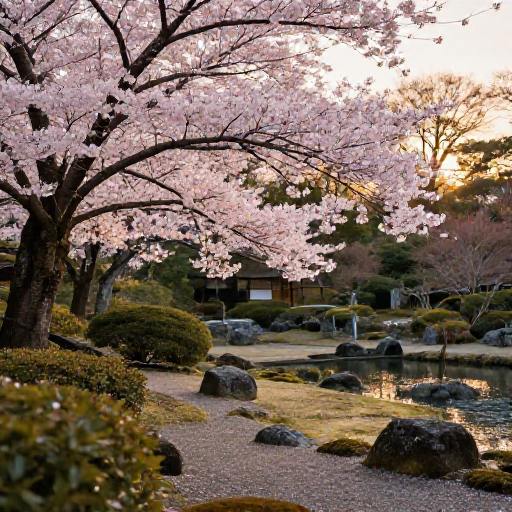

In [7]:
# =============================================================================
# TEST GENERATION - Try it out!
# =============================================================================

# Start with a simple prompt and small size for testing
test_prompt = "A serene Japanese garden with cherry blossoms, golden hour lighting, photorealistic"

# Generate!
image = generate_image(
    prompt=test_prompt,
    steps=6,          # 6 steps for balanced speed/quality
    size="512x512"    # Start small to verify everything works
)

# Display the result
if image:
    display(image)
else:
    print("Generation failed - check the error above")


🎨 Generating image...
   Prompt: A futuristic cyberpunk city at night, neon lights ...
   Size: 768x768
   Steps: 8
📦 Using cached model
   🔄 Running inference...


  0%|          | 0/8 [00:00<?, ?it/s]


✅ Done!


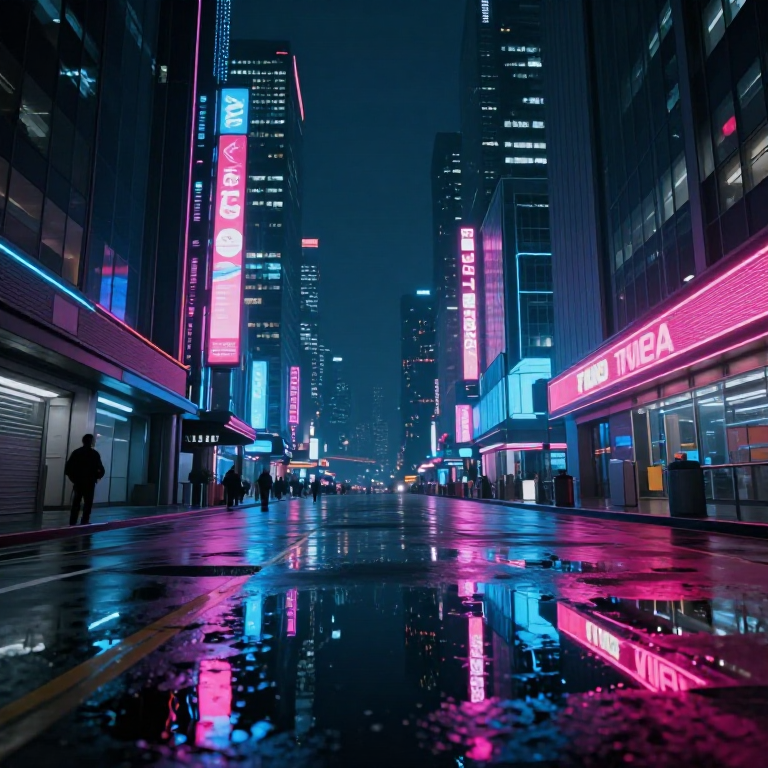

In [8]:
# =============================================================================
# TRY YOUR OWN PROMPTS!
# =============================================================================

# Modify this prompt and run the cell!
my_prompt = "A futuristic cyberpunk city at night, neon lights reflecting in puddles, cinematic"

my_image = generate_image(
    prompt=my_prompt,
    steps=8,          # More steps = better quality
    size="768x768"    # Medium resolution
)

if my_image:
    display(my_image)
    
    # Optional: Save your image!
    # my_image.save("my_generated_image.png")

## Part 8: Prompt Engineering Tips 💡

### What Makes a Good Prompt?

**Structure**: `[Subject] + [Details] + [Style] + [Quality modifiers]`

### Examples

| ❌ Bad | ✅ Good |
|--------|--------|
| "cat" | "A fluffy orange cat sleeping on a velvet cushion, soft natural lighting, detailed fur texture" |
| "landscape" | "Majestic mountain range at sunset, dramatic clouds, golden hour, landscape photography, 8k quality" |
| "portrait" | "Portrait of an elderly fisherman, weathered face, kind eyes, Rembrandt lighting, photorealistic" |

### Quality Keywords

Add these to improve output quality:
- `photorealistic`, `hyperrealistic`
- `8k`, `high detail`, `sharp focus`
- `cinematic lighting`, `golden hour`
- `award-winning`, `professional photography`

### Style Keywords

- **Photography**: `portrait`, `landscape`, `macro`, `street photography`
- **Art styles**: `oil painting`, `watercolor`, `digital art`, `anime`
- **Specific artists**: `in the style of Studio Ghibli`, `Monet-inspired`

## Part 9: Troubleshooting 🔧

### Common Issues

| Problem | Solution |
|---------|----------|
| "MPS out of memory" | Use smaller size (512x512) or close other apps |
| Slow generation | Reduce steps (4-6) or use smaller size |
| Blurry images | Increase steps (8-12) |
| Model download fails | Check internet connection, try again |
| Import errors | Run `pip install -r requirements.txt` |

### Memory Tips for Apple Silicon

1. Close memory-heavy apps (Chrome, Slack, etc.)
2. Restart your Mac to clear fragmented memory
3. Start with 512x512, then try larger sizes
4. Use fewer inference steps (4-6)